# Decision Trees

This notebook implements the custom decision tree algorithm for classification on the Palmer Penguins dataset. Here, decision trees are used to classify penguins by species based on input data for various numerical features, including bill length, bill width, flipper length, and body mass. The objective of this task is to validate the use of the custom decision tree class, and evaluate its performance for a multi-class and multi-feature classification problem.

The following sections are included in this notebook:
1. **Library Imports**
- Importing the necessary modules, packages, and libraries
- Specifies dependencies and preferred versions
2. **Data Loading and Cleaning**
- Loads the Palmer Penguins dataset with relevant features
- Drops outliers, duplicates, and missing data
- Creates arrays for the features and target variable
3. **Data Visualization**
- Visualizes the correlation between features using a heatmap
- Visualizes the distribution of two features with the target on a 2D color plot
4. **Decision Tree Implementation (2 Features)**
- Implements the custom-built decision tree algorithm with two input features  
- Visualizes the classification  
- Evaluates the results across multiple metrics  
5. **Decision Tree Implementation (Changing Parameters)**
- Implements the custom-built decision tree algorithm with various parameters (maximum depth, minimum samples to split)
- Examines the effect on model performance
6. **Decision Tree Implementation (Multiple Features)**
- Implements the custom-built decision tree algorithm with more than two features to ensure functionality
- Evaluates the results across multiple metrics
7. **Comparison with Existing Models**
- Runs the scikit-learn version of decision trees
- Compares the results with the custom-built class to verify the latter

*For a more comprehensive overview of the decision tree algorithm, code structure, and metrics used, see the associated [README](README.md).*

### Library Imports
This section imports the packages and modules required to run the decision tree algorithm. The following dependencies (with recommended versions) are required:
- Python 3.9.6
- Numpy 1.26.4
- Pandas 2.3.3
- Matplotlib 3.9.4
- Seaborn 0.13.2
- Sklearn 1.6.1

In [362]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
from rice_ml.preprocess import *
from rice_ml.supervised_learning.decisiontrees import *
from rice_ml.postprocess.classificationpost import *

### Data Loading & Cleaning
*Loading, preprocessing, and dividing data*

The data used in this notebook comes from Palmer Penguins, a common toy dataset for evaluating classification algorithms. It has been selected for its simplicity and clear feature relationships, and because it requires several data cleaning steps that showcase the `rice_ml` preprocessing modules, including handling missing values. The features of interest in this example are *species* (categorical and the target variable for classification), *bill length* (numeric), *bill depth* (numeric), *flipper length* (numeric), and *body mass* (numeric). 

The data is first loaded as a Pandas DataFrame. For classification, the *species* feature is converted into discrete integer values from 0 to 2, each representing a separate species.

In [363]:
# Loading the basic dataset and selecting features
penguins_df = sns.load_dataset("penguins")
penguin_features = penguins_df[[
    "species", 
    "bill_length_mm", 
    "bill_depth_mm", 
    "flipper_length_mm", 
    "body_mass_g"
]]

# Encoding the target as a numeric feature
penguin_features.loc[:, 'species'], uniques = pd.factorize(penguin_features['species'])

display(penguin_features)

,species,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
0,0,39.1,18.7,181.0,3750.0
1,0,39.5,17.4,186.0,3800.0
2,0,40.3,18.0,195.0,3250.0
3,0,NaN,NaN,NaN,NaN
4,0,36.7,19.3,193.0,3450.0
...,...,...,...,...,...
339,2,NaN,NaN,NaN,NaN
340,2,46.8,14.3,215.0,4850.0
341,2,50.4,15.7,222.0,5750.0
342,2,45.2,14.8,212.0,5200.0


The dataset contains some missing or NaN values (e.g., row 4) and may contain outlier or duplicate rows that will skew the results of the classification. To clean the data, we apply a series of preprocessing steps from the `rice_ml` preprocessing package, including dropping any rows with missing values, outliers, or that are identified to be duplicates of another.

In [364]:
# Cleaning the dataset (dropping rows with missing values, duplicates, or containing outliers)
penguin_features_cleaned_missing = missing_data(penguin_features, 'drop')
penguin_features_cleaned_outliers = outlier_identify(penguin_features_cleaned_missing, 'zscore', drop = True)
penguin_features_cleaned = duplicate_identify(penguin_features_cleaned_outliers, True)
print(f"Cleaned data (first five rows): \n {penguin_features_cleaned[0:5, :]}")

Cleaned data (first five rows): 
 [[   0.    39.1   18.7  181.  3750. ]
 [   0.    39.5   17.4  186.  3800. ]
 [   0.    40.3   18.   195.  3250. ]
 [   0.    36.7   19.3  193.  3450. ]
 [   0.    39.3   20.6  190.  3650. ]]


Two rows have been removed during cleaning, and the dataset no longer contains NaN values. For use in decision trees and for ease of visualization, the dataset must be split into the target (*species*) and the remaining features.

In [365]:
# Creating two arrays for target and other features
penguin_species = penguin_features_cleaned[:, 0]
penguin_feature_data = penguin_features_cleaned[:, 1:]
print(f"Array for penguin species (first five entries): \n {penguin_species[0:5]} \n \n \
Array for penguin feature data (first five rows): \n {penguin_feature_data[0:5]}")

Array for penguin species (first five entries): 
 [0. 0. 0. 0. 0.] 
 
 Array for penguin feature data (first five rows): 
 [[  39.1   18.7  181.  3750. ]
 [  39.5   17.4  186.  3800. ]
 [  40.3   18.   195.  3250. ]
 [  36.7   19.3  193.  3450. ]
 [  39.3   20.6  190.  3650. ]]


### Data Visualization
*Correlations and feature plotting*

Once the data has been appropriately cleaned, the relationships between variables can be visualized using a set of methods. We first visualize the correlations between features using a heatmap of a calculated correlation matrix, applied to the cleaned DataFrame that includes all relevant features. Doing so allows for the identification of features that are correlated with the target, and may thus be appropriate for classification using decision trees.

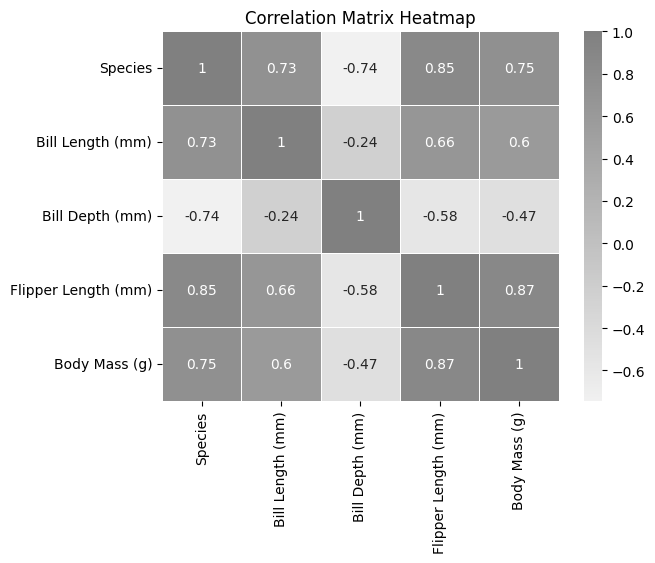

In [366]:
# Creating and plotting a correlation matrix with a heatmap
correlation_matrix = (pd.DataFrame(penguin_features_cleaned, columns = ['Species', 'Bill Length (mm)', 'Bill Depth (mm)', 'Flipper Length (mm)', 'Body Mass (g)'])).corr()
sns.heatmap(correlation_matrix, annot = True, cmap = sns.light_palette('gray', as_cmap=True), linewidths = 0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

Both bill length and body mass appear to be correlated with species (0.85 and 0.75, respectively). Consequently, these features are appropriate for a two-variable decision tree algorithm, and we will select them as the features for predicting species. To visualize the relationship between the three variables (*bill length*, *bill depth*, and *species*) and identify possible splits prior to formal analysis, we can create a two-dimensional plot of body mass versus bill length, with colors indicating species.

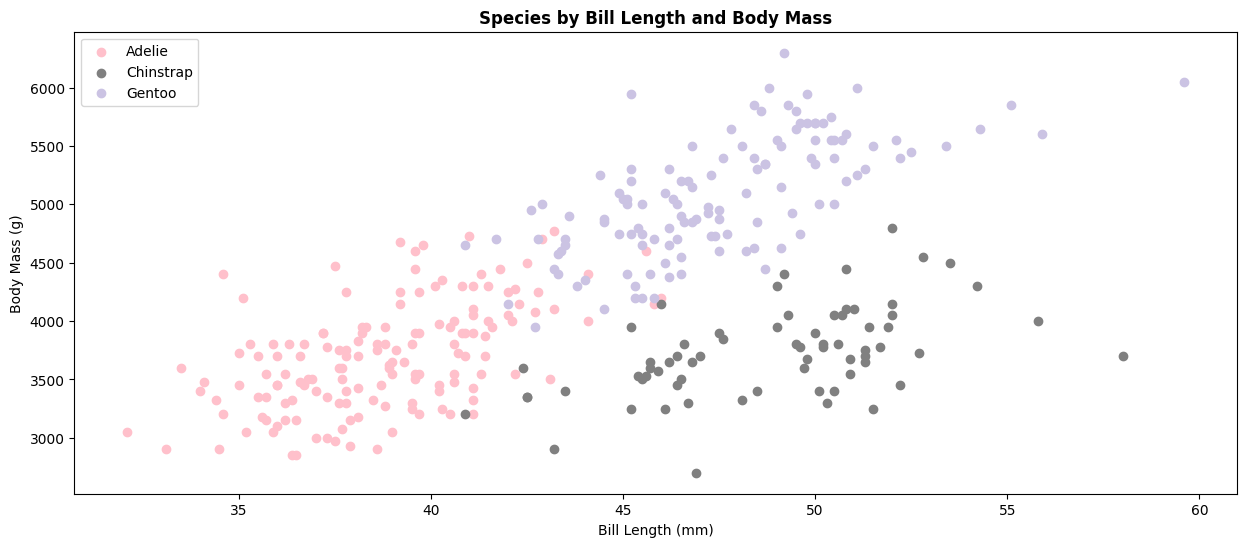

In [367]:
# Plotting bill length and body mass, color-coded by species
colors = {0: 'pink', 1: 'gray', 2: '#CBC3E3'}

plt.figure(figsize = (15, 6))
for species in np.unique(penguin_species):
    mask = (penguin_species == species)
    plt.scatter(penguin_feature_data[mask, 0], penguin_feature_data[mask, 3], label = species, color = colors[species])
    
plt.legend(['Adelie', 'Chinstrap', 'Gentoo'])
plt.title("Species by Bill Length and Body Mass", fontweight = 'bold')
plt.xlabel("Bill Length (mm)")
plt.ylabel("Body Mass (g)")

plt.show()

Three separate clusters corresponding to species appear from this plot, which suggests that it may be possible to find splits that accurately classify the data. Gentoo penguins tend to have a longer bill length and body mass, chinstrap penguins tend to have a longer bill length but smaller body mass, and Adelie penguins tend to have a smaller bill length and body mass. The distribution of this data suggests that it is a good candidate for assessing the custom decision tree model.

### Decision Tree Implementation (2 Features)
*Classification using decision trees with two features*

This section implements the custom decision tree class to classify penguin species based on body mass and bill length. It carries out the standardization, splitting, model fit, and prediction calculations.

Prior to fitting the decision tree model, we normalize the feature data using z-scores for each feature, calculated using the `preprocessing` package. This reduces the possibility that the relative scale of the feature will impact model results, and is standard practice in supervised learning. Feature normalization rescales each feature to prevent skewing results based on feature magnitude, ensuring that no one feature will overly contribute to model predictions.

In [368]:
# Standardizing the features
penguin_feature_data_normal = z_score_standardize(penguin_feature_data[:, [0, 3]])
print(f"Standardized feature data (first five rows): \n {penguin_feature_data_normal[0:5, :]}")

Standardized feature data (first five rows): 
 [[-0.88449874 -0.56414208]
 [-0.81112573 -0.50170305]
 [-0.66437972 -1.18853234]
 [-1.32473679 -0.93877623]
 [-0.84781224 -0.68902013]]


Once the data has been scaled, it is split into testing and training arrays. This ensures that the model is not trained and tested on the same set of data, allowing for unbiased evaluation of model performance and preventing overfitting. The data is split in a 70/30 proportion such that the training data is 70% of the total dataset, and the testing data 30%. There are 342 samples in the cleaned dataset, so the training array should have approximately 240 samples and the testing should have 102.

Because this is a classification problem where the classes may not be evenly represented within the data, stratification is used to split the testing and training sets. Stratification is a division method that first groups the data based on a given label, then randomly samples from each group to ensure that they are proportionally represented in both the testing and training data. This method prevents significant bias arising from disproportionate class counts by preserving relative distributions and ensuring that each class is represented in the training data. In this case, the stratification method is based on the target (*species*), which should guarantee that samples from each species are present in each set.

In [369]:
# Splitting the data into training and testing arrays
train_array, test_array, train_targets, test_targets = train_test(penguin_feature_data_normal, penguin_species, stratify = penguin_species, random_state = 438)

# Verifying sizes of each array
print(f"Shape of training array: {train_array.shape}")
print(f"Shape of training targets: {train_targets.shape}")
print(f"Shape of testing array: {test_array.shape}")
print(f"Shape of testing targets: {test_targets.shape}")

Shape of training array: (240, 2)
Shape of training targets: (240,)
Shape of testing array: (102, 2)
Shape of testing targets: (102,)


Next, we perform classification using decision trees by creating an instance of the `decision_tree` class from the supervised learning package, and fitting it on the training data. The previously unseen test data is then provided to the fitted model to predict the species labels. 

This decision tree algorithm has the following specifications:
- **Maximum Depth:** None
- **Minimum Samples to Split:** 2

In [370]:
# Fitting the model
tree = decision_tree()
tree.fit(train_array, train_targets)

# Predicting species based on testing data
prediction = tree.predict(test_array)

When the model has been successfully fitted and returns the species predictions for the test data, we evaluate its performance using a variety of visualization and scoring methods. These include plotting the predictions, displaying the tree and resultant splits on a meshgrid, displaying the overall confusion matrix, and calculating accuracy, precision, recall, and F1 scores for each class. For a description of these metrics, see this [README](README.md).

The plot below is a visualization of the decision tree accuracy on the test data. The leftmost subplot displays the overall distribution of body mass and bill length, color-coded for species; pale points are all data, and darker points indicate the gold-standard species labels for the test dataset. The rightmost subplot displays the same data, but with points that have been incorrectly classified by the decision tree in yellow.

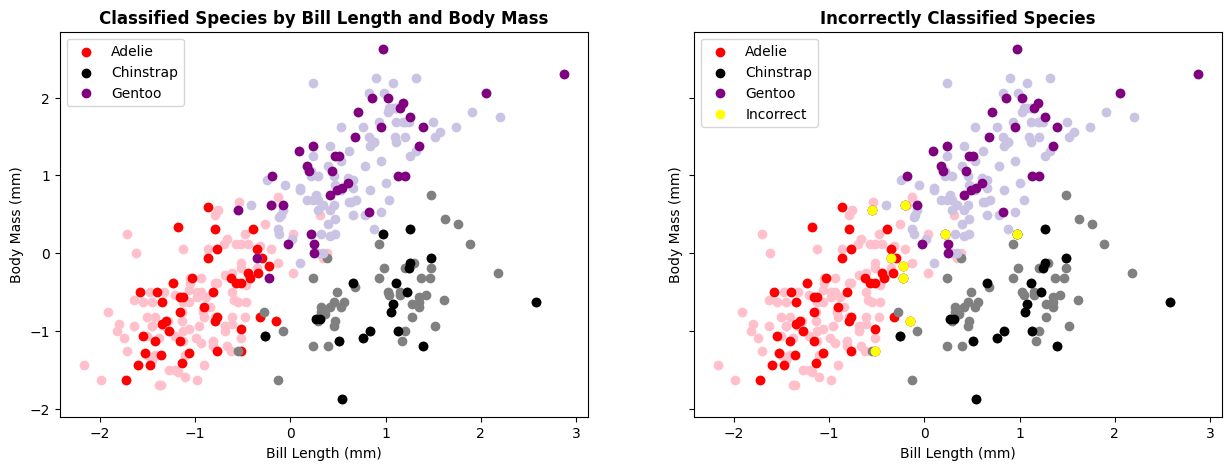

In [371]:
# Plotting bill length and body mass, color-coded by species
colors = {0: 'pink', 1: 'gray', 2: '#CBC3E3'}
colors_2 = {0: 'red', 1: 'black', 2: 'purple'}

fig, ax = plt.subplots(1, 2, figsize = (15, 5), sharex = True, sharey = True)

for species in np.unique(penguin_species):
    mask = (penguin_species == species)
    ax[0].scatter(penguin_feature_data_normal[mask, 0], penguin_feature_data_normal[mask, 1], label = species, color = colors[species])
    ax[1].scatter(penguin_feature_data_normal[mask, 0], penguin_feature_data_normal[mask, 1], label = species, color = colors[species])
    mask_new = (test_targets == species)
    ax[0].scatter(test_array[mask_new, 0], test_array[mask_new, 1], label = species, color = colors_2[species])
    ax[1].scatter(test_array[mask_new, 0], test_array[mask_new, 1], label = species, color = colors_2[species])

mask_incorrect = (test_targets != prediction)
ax[1].scatter(test_array[mask_incorrect, 0], test_array[mask_incorrect, 1], label = species, color = 'yellow')

handles, labels = plt.gca().get_legend_handles_labels()
selected_handles = [handles[i] for i in [1, 3, 5]]
selected_handles_2 = [handles[i] for i in [1, 3, 5, 6]]
ax[0].legend(handles = selected_handles, labels = ['Adelie', 'Chinstrap', 'Gentoo'])
ax[1].legend(handles = selected_handles_2, labels = ['Adelie', 'Chinstrap', 'Gentoo', 'Incorrect'])

ax[0].set_title("Classified Species by Bill Length and Body Mass", fontweight = 'bold')
ax[1].set_title("Incorrectly Classified Species", fontweight = 'bold')

for i in range(2):
    ax[i].set_xlabel("Bill Length (mm)")
    ax[i].set_ylabel("Body Mass (mm)")

plt.show()

The custom decision tree has good accuracy for species classification, but labels several points incorrectly, especially those that fall between visible clusters. We can visualize the decision tree itself to determine what feature values are considered thresholds for a split, and the boundaries of the tree can be plotted on a two-dimensional grid.

In [372]:
# Printing the decision tree
tree.print_tree()

Feature 0 <= -0.2975146760087176
	Feature 1 <= 0.590979904068365
		Feature 0 <= -0.5634918309261927
			Predict: 0
			Feature 1 <= -1.1729225806880477
				Predict: 1
				Predict: 0
		Feature 0 <= -0.47177557060982156
			Predict: 0
			Predict: 2
	Feature 1 <= -0.1582884080405536
		Feature 0 <= 0.13355174747822435
			Feature 0 <= -0.02236589505960588
				Predict: 1
				Predict: 0
			Predict: 1
		Feature 1 <= 0.7782969820955946
			Feature 0 <= 1.1699454890532115
				Feature 0 <= -0.12325378140761364
					Feature 0 <= -0.15994028553416173
						Predict: 0
						Feature 1 <= 0.09146769599575257
							Predict: 0
							Feature 1 <= 0.5129311215570193
								Predict: 2
								Predict: 0
					Feature 1 <= 0.15390672200482913
						Feature 0 <= 0.3628423982691501
							Feature 0 <= 0.3169842681109648
								Predict: 2
								Feature 1 <= -0.03341035602240053
									Predict: 0
									Predict: 2
							Feature 0 <= 0.6563344312815362
								Feature 1 <= -0.03341035602240053
									Pre

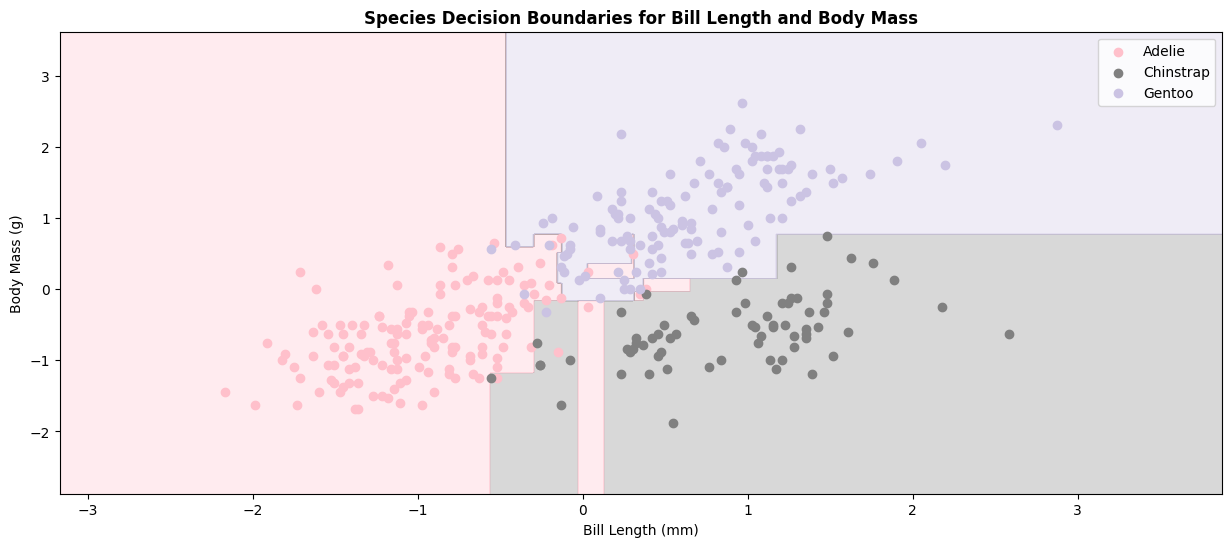

In [373]:
# Creating the meshgrid
x_min, x_max = penguin_feature_data_normal[:, 0].min() - 1, penguin_feature_data_normal[:, 0].max() + 1
y_min, y_max = penguin_feature_data_normal[:, 1].min() - 1, penguin_feature_data_normal[:, 1].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500),
                     np.linspace(y_min, y_max, 500))
grid_points = np.c_[xx.ravel(), yy.ravel()]
meshgrid_prediction = tree.predict(grid_points)
meshgrid_prediction = np.array(meshgrid_prediction, dtype = int).reshape(xx.shape)

# Plotting the decision boundaries
plt.figure(figsize=(15, 6))
cmap = ListedColormap(['pink', 'gray', '#CBC3E3'])
plt.contourf(xx, yy, meshgrid_prediction, alpha = 0.3, cmap = cmap)
colors = {0: 'pink', 1: 'gray', 2: '#CBC3E3'}
for species in np.unique(penguin_species):
    mask = (penguin_species == species)
    plt.scatter(penguin_feature_data_normal[mask, 0], penguin_feature_data_normal[mask, 1], label = species, color = colors[species])
plt.xlabel('Bill Length (mm)')
plt.ylabel('Body Mass (g)')
plt.title('Species Decision Boundaries for Bill Length and Body Mass', fontweight = 'bold')
plt.legend(['Adelie', 'Chinstrap', 'Gentoo'])
plt.show()

The decision tree results a series of fairly clear splits that mostly classify the data correctly. The splits become less clear within the region where clusters overlap, which is an expected result for decision trees and is likely causing several of the inaccurate predictions found in the prior plot. Regardless, the decision boundaries of this tree appear relatively successful in dividing the data, suggesting that the model is performing as expected.

For a more quantitative evaluation of the model, we plot the confusion matrix for each class, and produce the numerical evaluation metrics (accuracy, recall, precision, and F1 on the micro and macro scale).

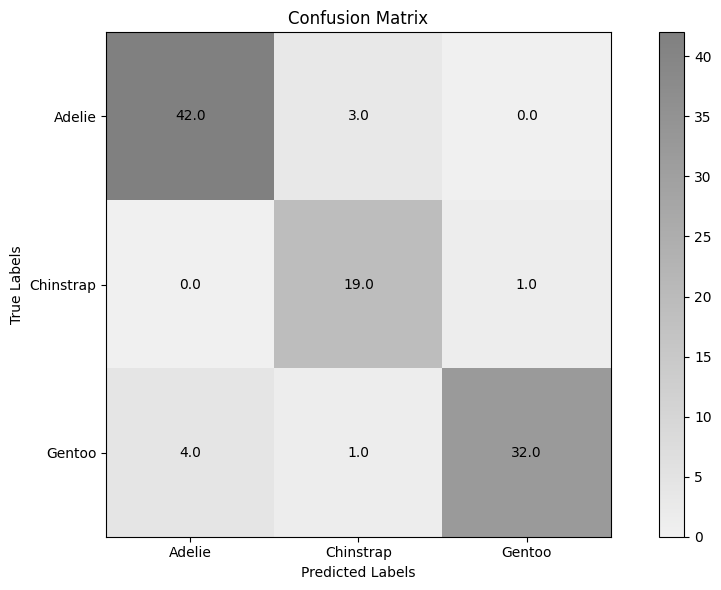

In [374]:
# Plotting the confusion matrix
conf_matrix = confusion_matrix(prediction, test_targets, conf_matrix_labels = ['Adelie', 'Chinstrap', 'Gentoo'])

In [375]:
# Evaluating model performance on various metrics
print_model_metrics(prediction, test_targets)

Model Metrics 
------------- 
Accuracy: 0.91 
Precision (Micro): 0.91 
Precision (Macro): 0.90 
Recall (Micro): 0.91 
Recall (Macro): 0.92 
F1 (Micro): 0.91 
F1 (Macro): 0.91


The results of the confusion matrix and evaluation metrics indicate that this decision tree model successfully classifies the species of a test sample based on body mass and bill length. The accuracy, precision, recall, and F1 scores calculated using micro and macro averages are all above 0.90, and the confusion matrix indicates very few incorrect classifications. As a whole, this validates the use of the custom decision tree for a two-feature, multi-class problem.

### Decision Tree Implementation (Changing Parameters)
*Altering maximum depth and minimum samples to split*

This section implements the custom decision tree for classifying species based on bill length and body mass, but systematically changes a parameter in the model to determine the effects on performance. It first evaluates the model for different maximum depths, using accuracy as the primary metric.

In [376]:
# Arrays for maximum depth and accuracy
max_depth_values = np.arange(1, 11)
accuracy_values_max_depth = np.full(len(max_depth_values), np.nan)

# Fitting and scoring the model for each maximum depth
for i in range(len(max_depth_values)):
    tree = decision_tree(max_depth = int(max_depth_values[i]))
    tree.fit(train_array, train_targets)
    prediction = tree.predict(test_array)
    accuracy = accuracy_score(prediction, test_targets)
    accuracy_values_max_depth[i] = accuracy

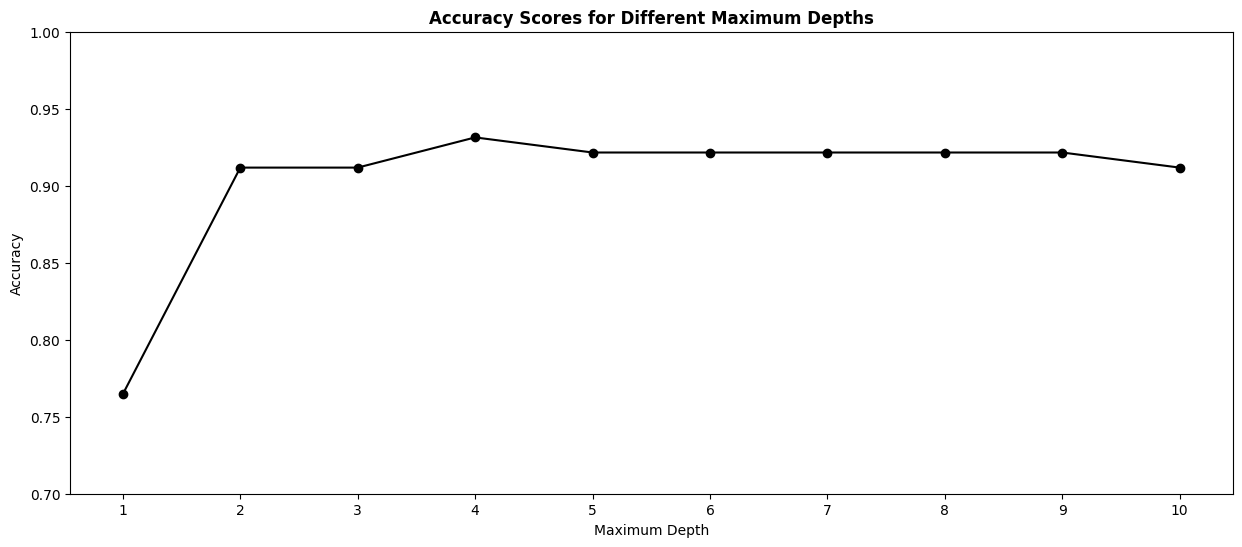

In [377]:
# Plotting the change in accuracy across different maximum depths
plt.figure(figsize = (15, 6))
plt.plot(max_depth_values, accuracy_values_max_depth, 'black')
plt.scatter(max_depth_values, accuracy_values_max_depth, color = 'black')
plt.title("Accuracy Scores for Different Maximum Depths", fontweight = 'bold')
plt.xlabel("Maximum Depth")
plt.ylabel("Accuracy")
plt.ylim(0.7, 1)
plt.xticks(range(1, 11))
plt.show()

When the maximum depth of the tree is restricted to low values (1 to 3), the accuracy is relatively low as well. However, at a maximum depth of 4 and beyond, the accuracy reaches above 0.90. The eventual plateau of accuracy as maximum depth increases suggests that an increase in the specified maximum depth only improves model performance up to a point (around 4), but does not significantly contribute to results beyond this. For the remainder of the analysis, we do not specify a particular depth at which the decision tree stops.

We now evaluate model performance with various values for the minimum samples required to split a node, with accuracy as the metric.

In [ ]:
# Arrays for minimum samples to split
min_samples_values = np.arange(1, 11)
accuracy_values_min_samples = np.full(len(min_samples_values), np.nan)

# Fitting and scoring the model for each minimum sample
for i in range(len(min_samples_values)):
    tree = decision_tree(min_samples_split = int(min_samples_values[i]))
    tree.fit(train_array, train_targets)
    prediction = tree.predict(test_array)
    accuracy = accuracy_score(prediction, test_targets)
    accuracy_values_min_samples[i] = accuracy

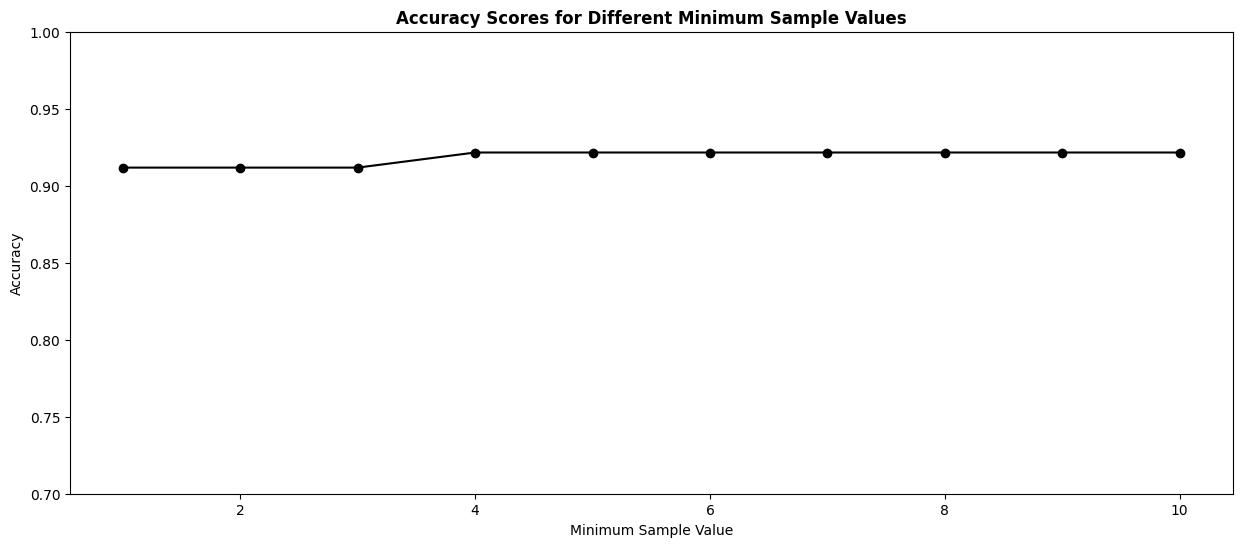

In [379]:
# Plotting the change in accuracy across different minimum split samples
plt.figure(figsize = (15, 6))
plt.plot(min_samples_values, accuracy_values_min_samples, 'black')
plt.scatter(min_samples_values, accuracy_values_min_samples, color = 'black')
plt.title("Accuracy Scores for Different Minimum Sample Values", fontweight = 'bold')
plt.xlabel("Minimum Sample Value")
plt.ylabel("Accuracy")
plt.ylim(0.7, 1)
plt.show()

The value set for the minimum samples needed to split does not appear to significantly impact the accuracy of the model. Performance is slightly lower for a value of 1 - 3, and increases at 4, then plateaus as the metric increases. However, the accuracy remains within approximately 0.90 to 0.93 for each value, suggesting a minimal impact on model performance. Therefore, we use the default minimum sample value of 2 for the remainder of the analysis.

### Decision Tree Implementation (Multiple Features)
*Classification using decision trees with multiple (four) features*

This section implements the custom decision tree class to classify penguin species based on bill depth, bill length, flipper length, and body mass. As before, it carries out the standardization, splitting, model fit, and prediction calculations.

Prior to fitting the decision tree model, we normalize the feature data using z-scores for each feature, again calculated using the `preprocessing` package. In this case, the entire feature data set (not simply the two selected features) is normalized and used in the decision tree analysis. The data is then split into training (70%) and testing arrays (30%) with the stratification method based on species label. Finally, a new instance of the decision tree class is created and fit with the training data, then used to classify samples in the testing data.

This decision tree algorithm has the following specifications:
- **Maximum Depth:** None
- **Minimum Samples to Split**: 2

In [380]:
# Standardizing the features
penguin_feature_data_normal_all_feat = z_score_standardize(penguin_feature_data)
print(f"Standardized feature data (first five rows): \n {penguin_feature_data_normal_all_feat[0:5, :]}")

Standardized feature data (first five rows): 
 [[-0.88449874  0.78544923 -1.41834665 -0.56414208]
 [-0.81112573  0.1261879  -1.06225022 -0.50170305]
 [-0.66437972  0.43046236 -0.42127665 -1.18853234]
 [-1.32473679  1.08972369 -0.56371522 -0.93877623]
 [-0.84781224  1.74898502 -0.77737308 -0.68902013]]


In [381]:
# Splitting the data into training and testing arrays
train_array_mult, test_array_mult, train_targets_mult, test_targets_mult = train_test(penguin_feature_data_normal_all_feat, penguin_species, stratify = penguin_species, random_state = 438)

# Verifying sizes of each array
print(f"Shape of training array: {train_array_mult.shape}")
print(f"Shape of training targets: {train_targets_mult.shape}")
print(f"Shape of testing array: {test_array_mult.shape}")
print(f"Shape of testing targets: {test_targets_mult.shape}")

Shape of training array: (240, 4)
Shape of training targets: (240,)
Shape of testing array: (102, 4)
Shape of testing targets: (102,)


In [382]:
# Fitting the model
tree_mult = decision_tree()
tree_mult.fit(train_array_mult, train_targets_mult)

# Predicting species based on testing data
prediction_mult = tree_mult.predict(test_array_mult)

Because the model takes in four features, there is no way to easily visualize the resulting classifications, as was possible with two features. Instead, model evaluation is done only using the confusion matrix and various performance metrics. We begin by printing the decision tree produced by the model.

In [383]:
# Printing the decision tree
tree_mult.print_tree()

Feature 2 <= 0.39774513290828706
	Feature 0 <= -0.29751467600872006
		Feature 1 <= -0.2541551775805498
			Feature 0 <= -0.8111257337803952
				Predict: 0
				Predict: 1
			Predict: 0
		Feature 3 <= -0.15828840804055366
			Predict: 1
			Feature 0 <= 0.3628423982691474
				Predict: 0
				Feature 1 <= 2.0279032722237917
					Predict: 1
					Predict: 0
	Feature 1 <= 0.20225651238031872
		Predict: 2
		Feature 0 <= 0.4820735366804295
			Predict: 0
			Predict: 1


This decision tree is smaller than the one produced using only two features, indicating more efficient or optimal splits at the found thresholds. To quantitatively assess model performance, we plot the confusion matrix and calculate a variety of evaluation metrics.

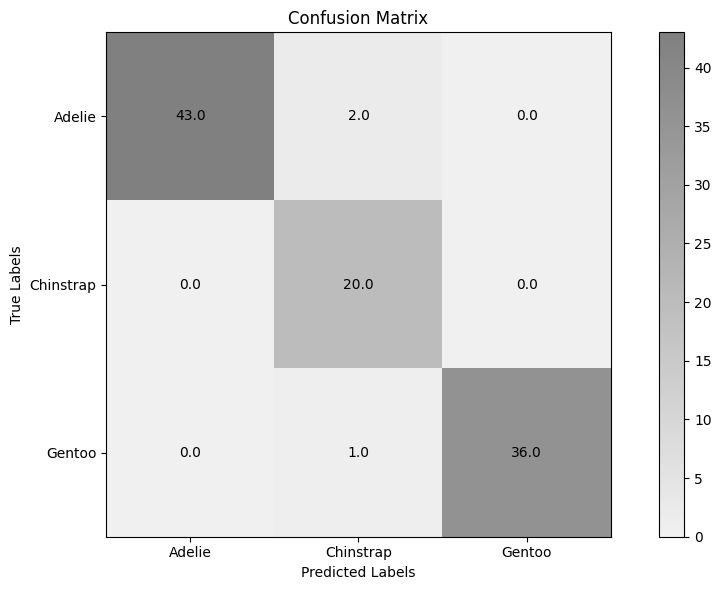

In [384]:
# Plotting the confusion matrix
conf_matrix = confusion_matrix(prediction_mult, test_targets_mult, conf_matrix_labels = ['Adelie', 'Chinstrap', 'Gentoo'])

In [385]:
# Evaluating model performance on various metrics
print_model_metrics(prediction_mult, test_targets_mult)

Model Metrics 
------------- 
Accuracy: 0.97 
Precision (Micro): 0.97 
Precision (Macro): 0.96 
Recall (Micro): 0.97 
Recall (Macro): 0.98 
F1 (Micro): 0.97 
F1 (Macro): 0.96


This model is more accurate than that containing only two features, achieving a classification accuracy of around 97%. Additionally, the micro and macro scores for precision, recall, and F1 are higher than the previous model, suggesting that including the additional features improves model performance. Very few samples have been misclassified, as shown in the confusion matrix. Consequently, the custom-build decision tree has been shown to be reliable for multi-class and multi-feature classification problems.

### Comparison with Existing Models
*Comparison with scikit-learn decision tree*

In order to ensure that the custom-built decision tree algorithm is functioning as intended and providing expected results, it is useful to compare its performance to a decision tree from established code. In this section, we rerun the analysis with all four features using the scikit-learn decision tree with a matching maximum depth (None) and minimum samples to split (2) to verify the results of the custom model.

In [388]:
# Creating a decision tree classifier using scikit-learn
from sklearn.tree import DecisionTreeClassifier
tree_sk = DecisionTreeClassifier(max_depth = None, min_samples_split = 2)
tree_sk.fit(train_array_mult, train_targets_mult)
prediction_sk = tree_sk.predict(test_array_mult)

In [390]:
# Printing the model metrics for the scikit-learn decision tree
print_model_metrics(prediction_sk, test_targets_mult)

Model Metrics 
------------- 
Accuracy: 0.99 
Precision (Micro): 0.99 
Precision (Macro): 0.98 
Recall (Micro): 0.99 
Recall (Macro): 0.99 
F1 (Micro): 0.99 
F1 (Macro): 0.99


The scikit-learn decision tree classifier has an accuracy, precision, recall, and F1 score that is similar to that of the custom-built decision tree, albeit slightly higher (around 99% accuracy). However, this discrepancy is not large enough to indicate a possible malfunction of the custom algorithm, and instead suggests that it is performing as would be expected on the given data. Therefore, the custom `rice_ml` decision tree is able to handle multi-class and multi-feature classification problems to an acceptable level.